In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

In [3]:
b1 = nn.Sequential(
    nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
    nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(
    nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
    nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                   Inception(128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                   Inception(160, (112, 224), (24, 64), 64),
                   Inception(128, (128, 256), (24, 64), 64),
                   Inception(112, (144, 288), (32, 64), 64),
                   Inception(256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                   Inception(384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())

C:\ProgramData\Anaconda3\envs\d2l\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [4]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.LazyLinear(10))

In [5]:
X = torch.rand(size=(1, 1, 96, 96), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


loss 0.254, train acc 0.904, test acc 0.895
3377.1 examples/sec on cuda:0


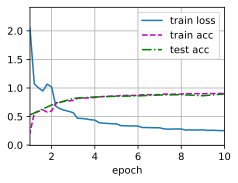

In [6]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size,
                                                    resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())